<a href="https://colab.research.google.com/github/cappelchi/Ancient-DNA-with-TPU/blob/master/Deep_Learning_on_Ancient_DNA_on_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Глубокое обучение и ископаемый ДНК

По мотивам работы Николая Осколкова

![alt text](https://www.thoughtco.com/thmb/9wjhjLVIZgTV6gNVFwX3BEN99T4=/2000x1503/filters:no_upscale():max_bytes(150000):strip_icc()/gobero_12-56a020515f9b58eba4af151a.jpg)

In [0]:
need_to_load = True

In [0]:
if need_to_load:
    !pip install pysam

In [0]:
!pip install tensorflow==2.1

In [0]:
import os
import numpy as np
import pysam
from google.colab import files
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from sklearn.model_selection import train_test_split
import datetime

In [4]:
if need_to_load:
    !wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam'
    !wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam.bai'
    !wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/French.bam'
    !wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/French.bam.bai'

--2020-01-16 09:00:37--  ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam
           => ‘Neandertal.bam’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/ensembl/neandertal/BAM_files ... done.
==> SIZE Neandertal.bam ... 4145696756
==> PASV ... done.    ==> RETR Neandertal.bam ... done.
Length: 4145696756 (3.9G) (unauthoritative)

Neandertal.bam      100%[===================>]   3.86G  17.1MB/s    in 4m 16s  

2020-01-16 09:04:55 (15.4 MB/s) - ‘Neandertal.bam’ saved [4145696756]

--2020-01-16 09:04:56--  ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam.bai
           => ‘Neandertal.bam.bai’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connecte

In [0]:
neand = pysam.AlignmentFile('Neandertal.bam', 'rb')

In [0]:
iter = neand.fetch('chr1', 0, 249000000)

In [0]:
neand_lengths =[]

In [0]:
for i in iter:
    neand_lengths.append(i.infer_query_length())

<function matplotlib.pyplot.show>

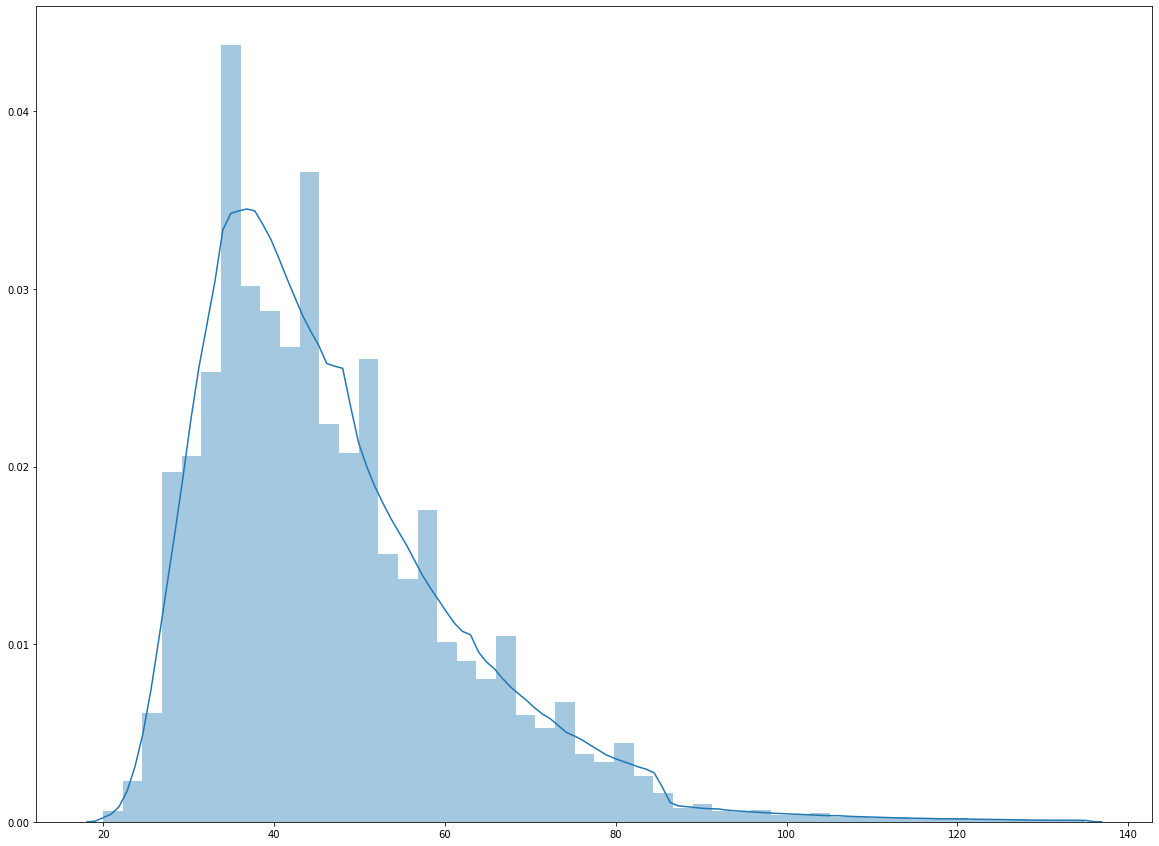

In [6]:
plt.figure(figsize=(20,15))
sns.distplot(neand_lengths)
plt.show

In [7]:
# Отбираем сиквенсы по 76 нуклеотидов
neand_seqs = []
for j in tqdm(range(1, 11)):
    iter = neand.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A') > 0 and s.count('C') > 0 and s.count('G') > 0 and s.count('T') > 0 and 'N' not in s:
                neand_seqs.append(i.get_forward_sequence())

# Read modern DNA sample
modern = pysam.AlignmentFile('French.bam', 'rb')
modern_seqs = []
for j in tqdm(range (1, 11)):
    iter = modern.fetch('chr' + str(j))
    for i in iter:
        if len(modern_seqs) == len(neand_seqs):
            break
        else:
            s = str(i.get_forward_sequence())
            if s.count('A') > 0 and s.count('C') > 0 and s.count('G') > 0 and s.count('T') > 0 and 'N' not in s:
                modern_seqs.append(i.get_forward_sequence())
sequences = neand_seqs + modern_seqs
labels = list(np.ones(len(neand_seqs))) + list(np.zeros(len(modern_seqs)))

100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


In [0]:
# Кодируем каждую букву ACGT (0001, 0010, 0100, 1000)
integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories= 'auto')
input_features = []

In [9]:
for sequence in tqdm(sequences):
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

100%|██████████| 530480/530480 [03:50<00:00, 2297.64it/s]


In [10]:
np.shape(input_features)

(530480, 76, 4)

In [11]:
np.set_printoptions(threshold = 40)
input_features = np.stack(input_features)
print('Образец сиквенса \n-----------------------')
print('ДНК сиквенс #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('Кодирование сиквенса one-hot #1:\n',input_features[0].T)

Образец сиквенса 
-----------------------
ДНК сиквенс #1:
 AAATCATCAG ... CTCCAAAACT
Кодирование сиквенса one-hot #1:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [12]:
# Разметка
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Категории:\n',labels.T)
print('One-hot кодировка:\n',input_labels.T)

Категории:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot кодировка:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [0]:
#input_labels = np.expand_dims(input_labels, axis = 1) # run if ses2sec Wavenet

In [0]:
#input_features = np.expand_dims(input_features, axis = -1) # run if 2DConv

In [0]:
input_features = input_features.astype(np.float32)
input_labels = input_labels.astype(np.float32)

In [19]:
'''
arr_label_name = 'dna_input_labels.npy'
arr_features_name = 'dna_input_features.npy'
path_l = F'/content/drive/My Drive/Colab Notebooks/Ancient DNA/{arr_label_name}'
path_f = F'/content/drive/My Drive/Colab Notebooks/Ancient DNA/{arr_features_name}'
np.save(path_l, input_labels)
np.save(path_f, input_features)
#np.save('dna_input_features', input_features)
'''

"\narr_label_name = 'dna_input_labels.npy'\narr_features_name = 'dna_input_features.npy'\npath_l = F'/content/drive/My Drive/Colab Notebooks/Ancient DNA/{arr_label_name}'\npath_f = F'/content/drive/My Drive/Colab Notebooks/Ancient DNA/{arr_features_name}'\nnp.save(path_l, input_labels)\nnp.save(path_f, input_features)\n#np.save('dna_input_features', input_features)\n"

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels,
    test_size = 0.25, random_state = 42
    )

In [15]:
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import tensorflow.keras.backend as K
#from keras.applications import DenseNet121 as DenseNet

print (tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [16]:
#Проверяем наличие GPU
gpus = tf.config.experimental.list_logical_devices("GPU")
if len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [0]:
batch_size = 1024
steps_per_epoch = 388
validation_steps = 129

In [18]:
def train_input_fn(train_features, train_labels, batch_size=batch_size, steps_per_epoch = steps_per_epoch):
                           
    dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)) 
    dataset = dataset.cache()    
    dataset = dataset.shuffle(steps_per_epoch, reshuffle_each_iteration = False)
    dataset = dataset.repeat() 
    dataset = dataset.batch(batch_size, drop_remainder=True)

    return dataset
train_input_fn(train_features, train_labels)

<BatchDataset shapes: ((1024, 76, 4), (1024, 2)), types: (tf.float32, tf.float32)>

In [19]:
def test_input_fn(test_features, test_labels, batch_size=batch_size, validation_steps = validation_steps):
    
    dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    dataset = dataset.cache()
    dataset = dataset.shuffle(validation_steps, reshuffle_each_iteration = False)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)

    return dataset
test_input_fn(test_features, test_labels)

<BatchDataset shapes: ((1024, 76, 4), (1024, 2)), types: (tf.float32, tf.float32)>

In [0]:
training_dataset = train_input_fn(train_features, train_labels)
test_dataset = test_input_fn(test_features, test_labels)

In [0]:
def make_model(
    nt_length = 76,
    n_filters = 32,
    batch_size = batch_size,
    learning_rate = 0.000025
    ):

    input_shape = (nt_length, 4)
    
    input_window = tf.keras.Input(
          name='input', 
          shape=input_shape, 
          batch_size = batch_size, 
          dtype=tf.float32
          )
    
    input = input_window
    x = Conv1D(filters = n_filters, kernel_size = 15, padding = 'same', 
                    kernel_initializer = 'he_uniform', 
                    #input_shape = input_shape, 
                    activation = 'selu',
                    kernel_regularizer=l2(0.001))(input)

    #merge = concatenate([x, input])
    x = Conv1D(filters = n_filters, kernel_size = 9, padding = 'same', 
                    kernel_initializer = 'he_uniform', 
                    activation = 'selu',
                    kernel_regularizer=l2(0.001))(x)


    #merge = concatenate([x, input])
    x = MaxPooling1D(pool_size = 9)(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_initializer = 'he_uniform', activation = 'sigmoid',
            kernel_regularizer = l2(0.001))(x)
    x = Dense(8, kernel_initializer = 'he_uniform', activation = 'sigmoid',
            kernel_regularizer = l2(0.001))(x)
    x = Dropout(.2)(x)
    output = Dense(2, activation = 'softmax')(x)
    model = tf.keras.Model(inputs = [input_window], outputs = [output])
    learning_rate = learning_rate
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate)
    #model.summary()
    model.compile(
                   optimizer = opt,
                   loss = 'binary_crossentropy',
                   metrics = [f1_metrics, 'accuracy'],
                   #metrics = [precision]
             )
    return model

In [0]:
#model = tf.keras.Model(inputs = [input_window], outputs = [output])

In [0]:
def f1_metrics(y_true, y_pred):
    # кастомная метрика F1    
    bs = K.cast(K.shape(y_pred)[1], 'float')
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0) 
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0) 
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) 
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) 

    p = tp / (bs * (tp + fp))
    r = tp / (bs * (tp + fn))    
    
    f1 = 2 * p * r / (p + r)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    # Кастомные колбэки
    def on_train_begin(self, logs={}):
        #self.f1_metrics = []
        self.f1 = 0.0 # здесь будем хранить макс f1
        
    def on_epoch_end(self, epoch, logs = {}):
        #print ('logs:', logs)
        pred_f1 = logs.get('val_f1_metrics')
      
        if pred_f1 > self.f1:
            self.f1 = pred_f1
            print(f'\n Best F1 {self.f1} on epoch: {epoch}')
            model.save_weights(f'Weights_{time.strftime("%H.%M", time.localtime())}_ep{epoch}_f1_{str(self.f1)[0:4]}.h5', overwrite = True)

In [0]:
with strategy.scope():
    # Компилируем модель
    model = make_model()
epochs = 200

In [27]:
if need_to_load:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

--2020-01-16 09:49:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.84.118, 34.230.145.192, 52.204.140.35, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.84.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  38.3MB/s    in 0.3s    

2020-01-16 09:49:04 (38.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [28]:
LOG_DIR = './log'  
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://1a0ced28.ngrok.io


In [29]:
NAME = f'Ancient_DNA {time.strftime("%Y-%m-%d-%H.%M.%S", time.localtime())}'
log_dir = f'./log/{NAME}'
tensorboard = TensorBoard(log_dir = log_dir)
checkpointer = ModelCheckpoint(filepath='./Ancient_DNA_1.h5',monitor='val_acc', verbose=0, 
                               save_best_only=True, save_weights_only = True) # save best model

start_training = datetime.datetime.now()
#Тренируем сетку
history = model.fit(training_dataset,                                                 
                         steps_per_epoch = steps_per_epoch,
                         epochs = 200,
                         validation_data = test_dataset,                        
                         validation_steps = validation_steps,
                         callbacks = [
                                      tensorboard,                                      
                                      MyCustomCallback()
                                     ]
                                   )
print('Training time = ', datetime.datetime.now() - start_training)

Train for 388 steps, validate for 129 steps
Epoch 1/200
382/388 [============================>.] - ETA: 0s - loss: 0.8461 - f1_metrics: 0.2633 - accuracy: 0.5813
 Best F1 0.2808821499347687 on epoch: 0
388/388 [==============================] - 12s 32ms/step - loss: 0.8453 - f1_metrics: 0.2636 - accuracy: 0.5825 - val_loss: 0.7642 - val_f1_metrics: 0.2809 - val_accuracy: 0.7447
Epoch 2/200
386/388 [============================>.] - ETA: 0s - loss: 0.7501 - f1_metrics: 0.2905 - accuracy: 0.7113
 Best F1 0.3009220361709595 on epoch: 1
388/388 [==============================] - 4s 10ms/step - loss: 0.7500 - f1_metrics: 0.2906 - accuracy: 0.7113 - val_loss: 0.7024 - val_f1_metrics: 0.3009 - val_accuracy: 0.7868
Epoch 3/200
385/388 [============================>.] - ETA: 0s - loss: 0.7093 - f1_metrics: 0.3035 - accuracy: 0.7490
 Best F1 0.30973026156425476 on epoch: 2
388/388 [==============================] - 4s 10ms/step - loss: 0.7092 - f1_metrics: 0.3035 - accuracy: 0.7491 - val_loss: 0

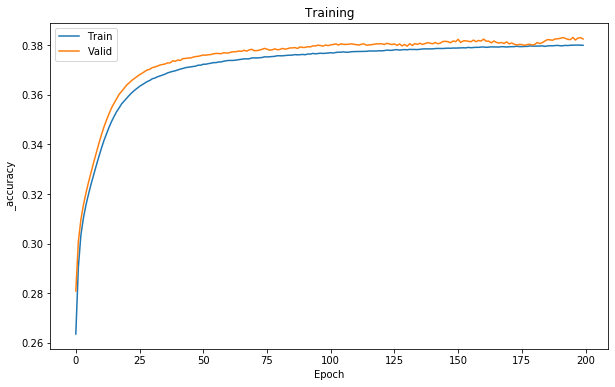

In [30]:
#визуализируем тренировку
plt.figure(figsize=(10,6))  
plt.plot(history.history['f1_metrics'])
plt.plot(history.history['val_f1_metrics'])

plt.xlabel('Epoch')
plt.ylabel('_accuracy')
plt.title('Training')
plt.legend(['Train','Valid'])

In [0]:
def save_all(model_wpath = 'Ancient_DNA.json'):
    saved_model = model.to_json()
    with open(model_wpath, 'w') as json_file:
        json_file.write(saved_model)

In [0]:
save_all()

In [0]:
def load_all (weights_file, model_wpath): 
    jfile = open(model_wpath, 'r')
    saved_model = jfile.read()
    jfile.close()
    loaded_model = model_from_json(saved_model)          
    loaded_model.load_weights(weights_file)
    
    return loaded_model

In [0]:
model.load_weights('Weights_10.02_ep195_f1_0.38.h5')

In [0]:
def predict_cpu (x, cpu_model, batch_size = batch_size):
    #предикт с учетом батча
    for i in tqdm(range(0, int(x.shape[0] / batch_size))):    
    
        if not(i):
            predict = np.array(cpu_model.predict(x[i * batch_size:(i + 1) * batch_size,:,:]))
        else:
            predict = np.append(predict, cpu_model.predict(x[i * batch_size:(i + 1) * batch_size,:,:]), axis =0)
        
    print(np.shape(predict))
    predict = np.append(predict, cpu_model.predict(x[-1024:,:,:])[- x.shape[0] % batch_size:, :], axis = 0)
    return predict

In [34]:
predict_DNA = predict_cpu(test_features, model)

100%|██████████| 129/129 [00:03<00:00, 39.89it/s]


(132096, 2)


In [0]:
from sklearn.metrics import confusion_matrix
import itertools

In [36]:
plt.figure(figsize = (10,8))
cm = confusion_matrix(np.argmax(test_labels, axis = 1), np.argmax(predict_DNA, axis = 1))
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[52233 13995]
 [ 7847 58545]]


<Figure size 720x576 with 0 Axes>

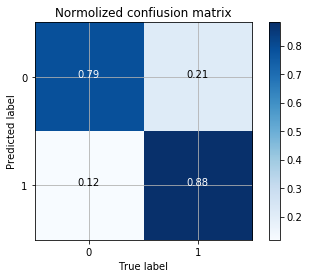

In [37]:
#визуализируем предикт
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normolized confiusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0,1]);plt.yticks([0,1])
plt.grid('off')
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, f'{np.round(cm[i,j], 2)}',
    horizontalalignment = 'center',
    color = 'white' if cm[i,j] > 0.5 else 'black')
plt.show()

In [38]:
print(np.shape(test_features), np.shape(test_labels), np.shape(predict_DNA))

(132620, 76, 4) (132620, 2) (132620, 2)


#Что дальше?
1. Попробуем задать контекст геномным последовательностям используя библиотеку Genomic-ULMFiT
2. Токенизируем последовательности
3. Создадим эмбеддинги либо возьмём готовую (трансфер лернинг)
4. LSTM архитектура 
5. Классификация последовтельностей разной длины с учетом контекста